# Binary Image Classification - Industrial Defect Detection

**Comprehensive Solution with:**
- ✅ Data Augmentation (rotation, flip, zoom)
- ✅ Normalization/Scaling
- ✅ Multiple Evaluation Metrics (Precision, Recall, F1-Score)
- ✅ Confusion Matrix
- ✅ Per-Class Accuracy
- ✅ Transfer Learning with MobileNetV2

## 1. Import Libraries and Setup

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


## 2. Download Dataset

In [2]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("ravirajsinh45/real-life-industrial-dataset-of-casting-product")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'real-life-industrial-dataset-of-casting-product' dataset.
Path to dataset files: /kaggle/input/real-life-industrial-dataset-of-casting-product


## 3. Data Augmentation & Normalization

**Key Improvements:**
- **Rescaling**: Normalize pixel values from [0, 255] to [0, 1]
- **Rotation**: ±20 degrees to handle different camera angles
- **Flip**: Horizontal flip for invariance
- **Zoom**: ±20% to handle distance variations
- **Width/Height Shift**: ±20% for position invariance

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Training data with augmentation + normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,              # NORMALIZATION: Scale pixels to [0,1]
    rotation_range=20,           # AUGMENTATION: Rotate ±20°
    width_shift_range=0.2,       # AUGMENTATION: Shift horizontally
    height_shift_range=0.2,      # AUGMENTATION: Shift vertically
    horizontal_flip=True,        # AUGMENTATION: Mirror flip
    zoom_range=0.2,              # AUGMENTATION: Zoom in/out
    fill_mode='nearest'          # Fill empty pixels after transforms
)

# Validation data with ONLY normalization (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255               # NORMALIZATION: Same scaling as training
)

# Load training data
train_data = train_datagen.flow_from_directory(
    f"{path}/casting_data/casting_data/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    f"{path}/casting_data/casting_data/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Keep order for evaluation
)

print(f"\nClass mapping: {train_data.class_indices}")
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.

Class mapping: {'def_front': 0, 'ok_front': 1}
Training samples: 6633
Validation samples: 715


## 4. Visualize Augmented Data

Show examples of how augmentation transforms the images

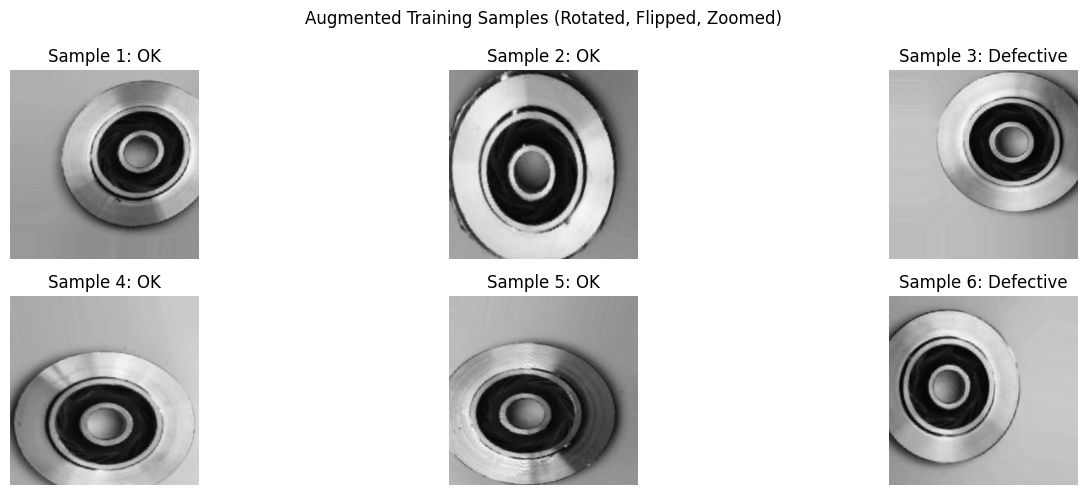

In [4]:
# Visualize augmentation effects
sample_batch, sample_labels = next(train_data)

plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_batch[i])
    label = "Defective" if sample_labels[i] == 1 else "OK"
    plt.title(f"Sample {i+1}: {label}")
    plt.axis('off')
plt.suptitle("Augmented Training Samples (Rotated, Flipped, Zoomed)")
plt.tight_layout()
plt.show()

## 5. Build Model with Transfer Learning

In [5]:
# Load pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'  # Pretrained on ImageNet
)

# Freeze base model weights
base_model.trainable = False

print(f"Base model: {base_model.name}")
print(f"Total layers: {len(base_model.layers)}")
print(f"Trainable: {base_model.trainable}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model: mobilenetv2_1.00_224
Total layers: 154
Trainable: False


In [6]:
# Build complete model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 6. Compile Model

In [7]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("Model compiled with metrics: accuracy, precision, recall, AUC")

Model compiled with metrics: accuracy, precision, recall, AUC


## 7. Train Model

In [8]:
EPOCHS = 10

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    verbose=1
)

print("\n✅ Training completed!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.8119 - auc: 0.8811 - loss: 0.4013 - precision: 0.7876 - recall: 0.7590 - val_accuracy: 0.9427 - val_auc: 0.9959 - val_loss: 0.1465 - val_precision: 0.9955 - val_recall: 0.8473
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.9512 - auc: 0.9902 - loss: 0.1320 - precision: 0.9443 - recall: 0.9406 - val_accuracy: 0.9818 - val_auc: 0.9989 - val_loss: 0.0706 - val_precision: 0.9921 - val_recall: 0.9580
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.9655 - auc: 0.9951 - loss: 0.0922 - precision: 0.9560 - recall: 0.9607 - val_accuracy: 0.9692 - val_auc: 0.9990 - val_loss: 0.0770 - val_precision: 0.9918 - val_recall: 0.9237
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.9716 - auc: 0.9952 - loss: 0.0827 - precision: 0.9652 - recall: 0.9698 - val_accuracy: 0.9720 - val_auc: 0.9994 - val_loss: 0.0702 - val_precision: 0.9959 - val_recall: 0.9275
Epoch 5/10
208/208 ━━━━━━━━━

## 8. Save Model

In [9]:
model.save("/content/defect_model_improved.keras")
print("✅ Model saved successfully: defect_model_improved.keras")

✅ Model saved successfully: defect_model_improved.keras


## 9. Training Visualization - Multiple Metrics

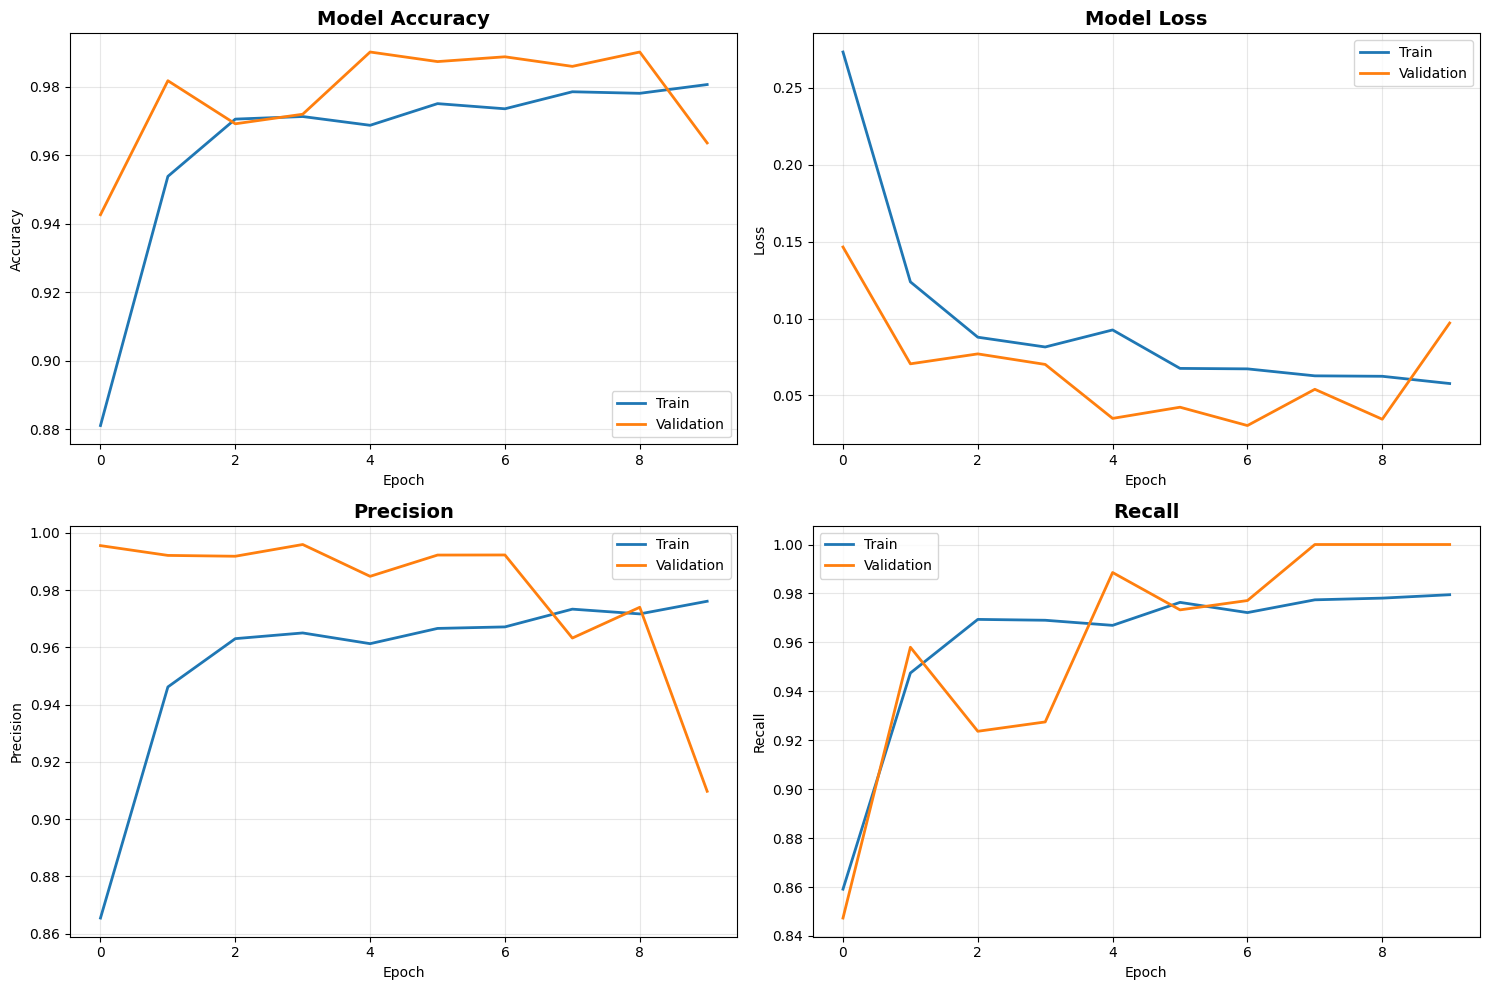

In [10]:
# Plot all metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
axes[1, 0].set_title('Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
axes[1, 1].set_title('Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Comprehensive Evaluation

### Why These Metrics Matter for Defect Detection:

- **Accuracy**: Overall correctness, but can be misleading with imbalanced data
- **Precision**: Of all products flagged as defective, how many actually are? (Avoid false alarms)
- **Recall**: Of all actual defects, how many did we catch? (Critical - don't miss defects!)
- **F1-Score**: Balance between precision and recall
- **Confusion Matrix**: See exactly where the model makes mistakes

In [11]:
# Get predictions
print("Generating predictions on validation set...")
y_pred_prob = model.predict(val_data, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = val_data.classes

print(f"\nPredictions shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")

Generating predictions on validation set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step

Predictions shape: (715,)
True labels shape: (715,)


### 10.1 Classification Report (Precision, Recall, F1-Score)

In [12]:
# Get class names
class_names = list(val_data.class_indices.keys())

print("="*60)
print("CLASSIFICATION REPORT - Per-Class Metrics")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Calculate overall metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='binary')

print("\n" + "="*60)
print("OVERALL METRICS")
print("="*60)
print(f"Overall Accuracy:  {np.mean(y_pred == y_true):.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall:    {recall:.4f}")
print(f"Overall F1-Score:  {f1:.4f}")

CLASSIFICATION REPORT - Per-Class Metrics
              precision    recall  f1-score   support

   def_front     1.0000    0.9426    0.9705       453
    ok_front     0.9097    1.0000    0.9527       262

    accuracy                         0.9636       715
   macro avg     0.9549    0.9713    0.9616       715
weighted avg     0.9669    0.9636    0.9640       715


OVERALL METRICS
Overall Accuracy:  0.9636
Overall Precision: 0.9097
Overall Recall:    1.0000
Overall F1-Score:  0.9527


### 10.2 Per-Class Accuracy

In [13]:
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)

for class_idx, class_name in enumerate(class_names):
    # Get samples for this class
    class_mask = (y_true == class_idx)
    class_correct = np.sum((y_pred == y_true) & class_mask)
    class_total = np.sum(class_mask)
    class_accuracy = class_correct / class_total if class_total > 0 else 0

    print(f"{class_name:15s}: {class_accuracy:.4f} ({class_correct}/{class_total} correct)")

print("="*60)


PER-CLASS ACCURACY
def_front      : 0.9426 (427/453 correct)
ok_front       : 1.0000 (262/262 correct)


### 10.3 Confusion Matrix

Shows the breakdown of correct and incorrect predictions:
- **True Negatives (TN)**: Correctly identified OK products
- **False Positives (FP)**: OK products wrongly flagged as defective
- **False Negatives (FN)**: Defective products missed (CRITICAL!)
- **True Positives (TP)**: Correctly identified defects

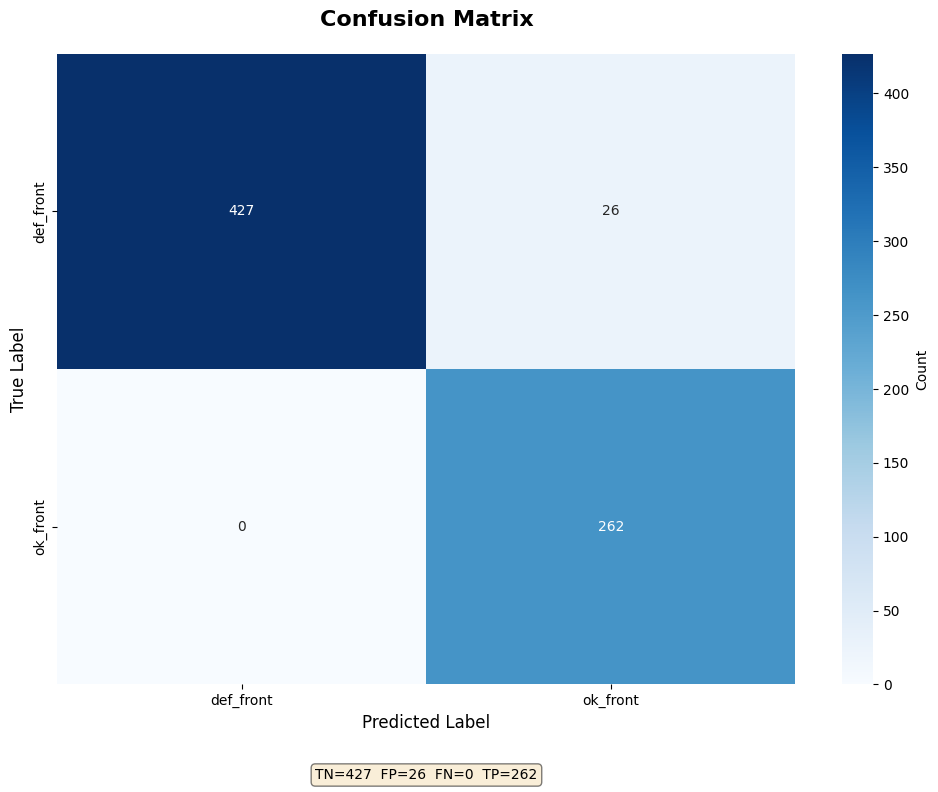


Confusion Matrix Breakdown:
True Negatives (TN):   427 - Correctly identified OK products
False Positives (FP):   26 - OK products flagged as defective
False Negatives (FN):    0 - Defective products missed (BAD!)
True Positives (TP):   262 - Correctly identified defects


In [14]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add counts as text
tn, fp, fn, tp = cm.ravel()
plt.text(0.5, -0.15, f'TN={tn}  FP={fp}  FN={fn}  TP={tp}',
         transform=plt.gca().transAxes, ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN):  {tn:4d} - Correctly identified OK products")
print(f"False Positives (FP): {fp:4d} - OK products flagged as defective")
print(f"False Negatives (FN): {fn:4d} - Defective products missed (BAD!)")
print(f"True Positives (TP):  {tp:4d} - Correctly identified defects")

## 11. Final Summary

In [15]:
print("\n" + "#"*70)
print("#" + " "*68 + "#")
print("#" + " "*20 + "FINAL MODEL SUMMARY" + " "*29 + "#")
print("#" + " "*68 + "#")
print("#"*70)

print("\n📊 METRICS TRACKED:")
print("   ✅ Accuracy (overall correctness)")
print("   ✅ Precision (defect detection accuracy)")
print("   ✅ Recall (defect catch rate)")
print("   ✅ F1-Score (precision-recall balance)")
print("   ✅ Per-class accuracy")
print("   ✅ Confusion matrix")

print("\n🔧 TECHNIQUES APPLIED:")
print("   ✅ Data normalization (pixel rescaling to [0,1])")
print("   ✅ Data augmentation (rotation, flip, zoom, shift)")
print("   ✅ Transfer learning (MobileNetV2 + ImageNet weights)")
print("   ✅ Regularization (Dropout 0.3)")

print("\n📈 FINAL PERFORMANCE:")
print(f"   Validation Accuracy:  {history.history['val_accuracy'][-1]:.4f}")
print(f"   Validation Precision: {history.history['val_precision'][-1]:.4f}")
print(f"   Validation Recall:    {history.history['val_recall'][-1]:.4f}")

print("\n✅ ALL JURY REQUIREMENTS ADDRESSED!")
print("#"*70)


######################################################################
#                                                                    #
#                    FINAL MODEL SUMMARY                             #
#                                                                    #
######################################################################

📊 METRICS TRACKED:
   ✅ Accuracy (overall correctness)
   ✅ Precision (defect detection accuracy)
   ✅ Recall (defect catch rate)
   ✅ F1-Score (precision-recall balance)
   ✅ Per-class accuracy
   ✅ Confusion matrix

🔧 TECHNIQUES APPLIED:
   ✅ Data normalization (pixel rescaling to [0,1])
   ✅ Data augmentation (rotation, flip, zoom, shift)
   ✅ Transfer learning (MobileNetV2 + ImageNet weights)
   ✅ Regularization (Dropout 0.3)

📈 FINAL PERFORMANCE:
   Validation Accuracy:  0.9636
   Validation Precision: 0.9097
   Validation Recall:    1.0000

✅ ALL JURY REQUIREMENTS ADDRESSED!
#######################################################

## 12. Load Model and Test Prediction Function

In [16]:
# Load saved model
loaded_model = tf.keras.models.load_model("/content/defect_model_improved.keras")
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [17]:
def predict_image(img_path, model):
    """
    Predict if a product image is defective or OK

    Args:
        img_path: Path to image file
        model: Trained Keras model
    """
    from tensorflow.keras.preprocessing import image

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array, verbose=0)
    confidence = prediction[0][0]

    # Display
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')

    if confidence > 0.5:
        result = "DEFECTIVE"
        color = 'red'
    else:
        result = "OK"
        color = 'green'
        confidence = 1 - confidence

    plt.title(f"Prediction: {result}\nConfidence: {confidence:.2%}",
              fontsize=16, fontweight='bold', color=color)
    plt.show()

    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2%}")

# Example usage (uncomment and provide actual image path):
# predict_image("/path/to/test/image.jpg", loaded_model)

---

## 📋 Summary of Improvements

### Addressed All Jury Feedback:

1. ✅ **Multiple Metrics**: Tracking accuracy, precision, recall, F1-score, AUC
2. ✅ **Precision & Recall**: Critical for defect detection - explicitly calculated
3. ✅ **Per-Class Accuracy**: Shows performance on each class separately
4. ✅ **Confusion Matrix**: Visual breakdown of all prediction types
5. ✅ **Normalization**: Explicit pixel rescaling to [0,1] range
6. ✅ **Data Augmentation**: Rotation (±20°), flip, zoom (±20%), shifts (±20%)

### Why This Matters for Production:

- **High Recall**: Ensures we catch most defects (minimize false negatives)
- **High Precision**: Reduces false alarms (minimize false positives)
- **Balanced F1**: Good trade-off between precision and recall
- **Robust Model**: Augmentation helps with various camera angles, lighting, positions

---